In [1]:
# Importing all the necessary libraries
import numpy as np
import pandas as pd
from collections import Counter
from datetime import datetime
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso
import xgboost
from xgboost import plot_importance
from xgboost import XGBClassifier
import time
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import auc, roc_curve, classification_report
import math
from sklearn.model_selection import RepeatedKFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

#import sys
#!{sys.executable} -m pip install cufflinks
import plotly
import plotly.offline as py
py.init_notebook_mode(connected=True)
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.offline as offline
# import cufflinks and offline mode
import cufflinks as cf
cf.go_offline()

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTENC
from collections import Counter

from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.constraints import maxnorm
from keras.callbacks import EarlyStopping

C:\Users\yijia\anaconda3\envs\py3-TF2.0\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## Load Dataset

In [2]:
data = pd.read_csv('conversion_data.csv')
data.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316200 entries, 0 to 316199
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   country              316200 non-null  object
 1   age                  316200 non-null  int64 
 2   new_user             316200 non-null  int64 
 3   source               316200 non-null  object
 4   total_pages_visited  316200 non-null  int64 
 5   converted            316200 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 14.5+ MB


##### - Identifying the wrong data and deal with it

In [5]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,316200.0,30.569858,8.271802,17.0,24.0,30.0,36.0,123.0
new_user,316200.0,0.685465,0.464331,0.0,0.0,1.0,1.0,1.0
total_pages_visited,316200.0,4.872966,3.341104,1.0,2.0,4.0,7.0,29.0
converted,316200.0,0.032258,0.176685,0.0,0.0,0.0,0.0,1.0


In [14]:
for col in data.columns:
    uniques = sorted(data[col].unique())
    print('{0:20s}{1:2d}\t'.format(col, len(uniques)), uniques)

country              4	 ['China', 'Germany', 'UK', 'US']
age                 60	 [17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 72, 73, 77, 79, 111, 123]
new_user             2	 [0, 1]
source               3	 ['Ads', 'Direct', 'Seo']
total_pages_visited 29	 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
converted            2	 [0, 1]


In [16]:
Counter(data['country'])

Counter({'UK': 48450, 'US': 178092, 'China': 76602, 'Germany': 13056})

A few quick observations:
- The site is probability a US site, althought it does have a large Chinease user base as well.
- User base is pretty young
- Conversion rate at around 3% is industry standard. It makes sense. 
- Everything seems to make sense except the max age 123yrs

### Remove outliers

In [18]:
data[data['age']>90]

,country,age,new_user,source,total_pages_visited,converted
90928,Germany,123,0,Seo,15,1
295581,UK,111,0,Ads,10,1


In [19]:
data = data[data['age'] < 100]

### EDA

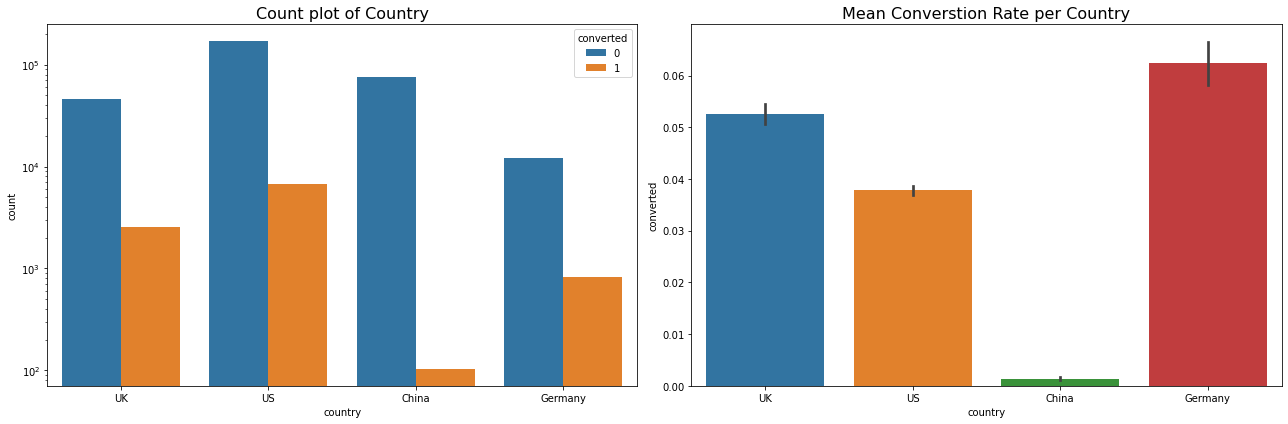

In [21]:
# Visualization of different countries
grouped = data[['country', 'converted']].groupby('country').mean().reset_index()
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
sns.countplot(x='country', hue='converted', data= data, ax=ax[0])
ax[0].set_title('Count plot of Country', fontsize = 16)
ax[0].set_yscale('log')
sns.barplot(x='country', y='converted', data=data, ax=ax[1])
ax[1].set_title('Mean Converstion Rate per Country', fontsize = 16)
plt.tight_layout()
plt.show()

It clearly looks like Chinese convert at a much lower rate than other countries.

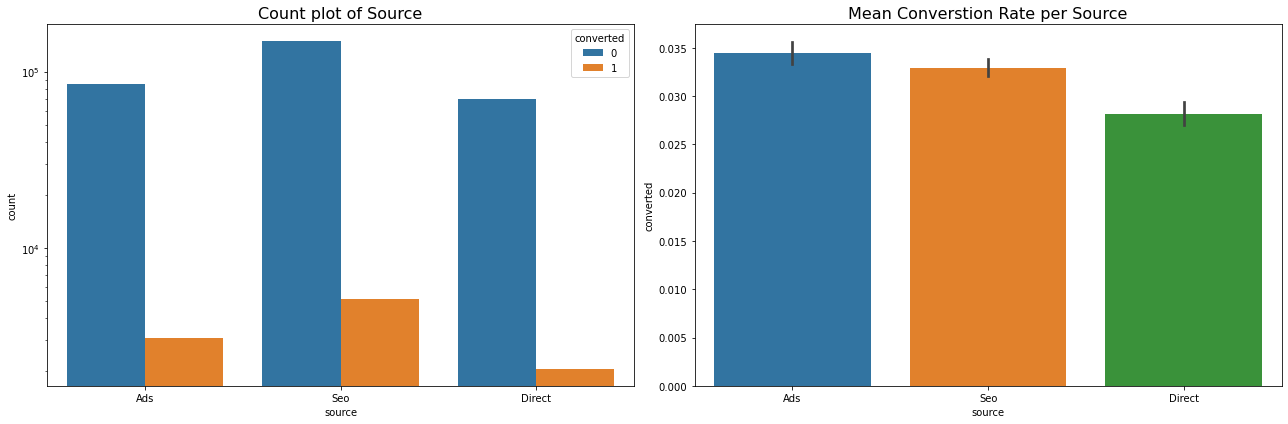

In [25]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (18, 6))
sns.countplot(x='source', hue = 'converted', data = data, ax=ax[0])
ax[0].set_title('Count plot of Source', fontsize = 16)
ax[0].set_yscale('log')
sns.barplot(x='source', y='converted', data=data, ax=ax[1])
ax[1].set_title('Mean Converstion Rate per Source', fontsize = 16)
plt.tight_layout()
plt.show()

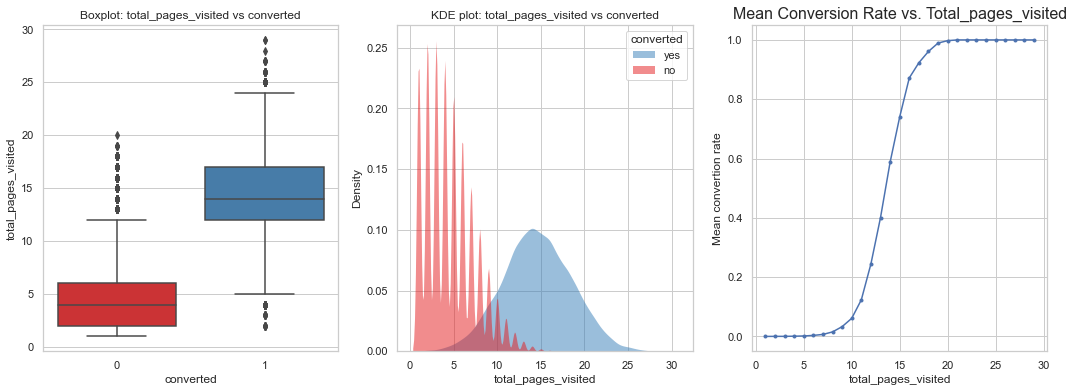

In [36]:
# Visualization of different sources
grouped = data[['total_pages_visited', 'converted']].groupby('total_pages_visited').mean().reset_index()

f,ax = plt.subplots(1,3, figsize = (18,6))
sns.set(style="whitegrid")
sns.boxplot(x="converted", y="total_pages_visited",  data=data, palette="Set1",ax=ax[0])
ax[0].set_title('Boxplot: total_pages_visited vs converted')
ax[0].set(xlabel='converted', ylabel='total_pages_visited')
sns.kdeplot(
   data=data, x="total_pages_visited", hue="converted",
   fill=True, common_norm=False, palette="Set1",
   alpha=.5, linewidth=0,ax=ax[1]
)
ax[1].set_title('KDE plot: total_pages_visited vs converted')
ax[1].set(xlabel='total_pages_visited')
ax[1].legend(title="converted",labels=['yes', 'no'])
ax[2].plot(grouped['total_pages_visited'], grouped['converted'], '.-')
ax[2].set_title('Mean Conversion Rate vs. Total_pages_visited', fontsize=16)
ax[2].set_xlabel('total_pages_visited')
ax[2].set_ylabel('Mean convertion rate')
ax[2].grid(True)
plt.show()

Definitely spending more time on the site implies higher probability of conversion!

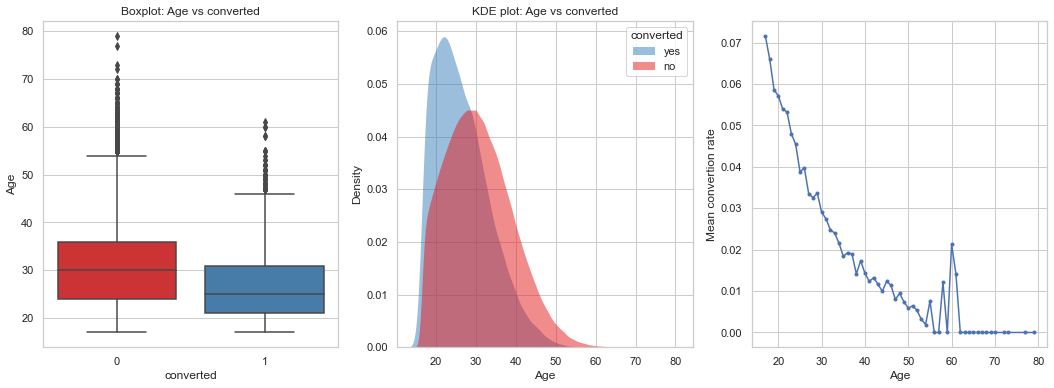

In [41]:
# Visualization of age
grouped = data[['age', 'converted']].groupby('age').mean().reset_index()
f,ax = plt.subplots(1, 3, figsize = (18, 6))
sns.set(style = 'whitegrid')
sns.boxplot(x = 'converted', y = 'age', data = data, palette = "Set1", ax = ax[0])
ax[0].set_title('Boxplot: Age vs converted')
ax[0].set(xlabel='converted', ylabel='Age')
sns.kdeplot(data = data, x = 'age', hue = 'converted', fill = True, 
            common_norm = False, palette = 'Set1', alpha = 0.5, linewidth = 0, ax = ax[1])
ax[1].set_title('KDE plot: Age vs converted')
ax[1].set(xlabel='Age')
ax[1].legend(title="converted",labels=['yes', 'no'])
ax[2].plot(grouped['age'], grouped['converted'], '.-')
ax[2].set(xlabel='Age', ylabel='Mean convertion rate')
ax[2].grid(True)
plt.show()

Young people tend to convert, however:
See some spike around age 60, which is weired. Check if this is a default age setting. Some people don't disclose their ages. 

## Machine Learning

In [45]:
import h2o
from h2o.frame import H2OFrame
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.grid.grid_search import H2OGridSearch


In [58]:
# Initialize H2O cluster
h2o.init()
h2o.remove_all()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; OpenJDK 64-Bit Server VM JBR-11.0.13.7-1751.21-jcef (build 11.0.13+7-b1751.21, mixed mode)
  Starting server from C:\Users\yijia\anaconda3\envs\py3-TF2.0\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\yijia\AppData\Local\Temp\tmpx8ode6pz
  JVM stdout: C:\Users\yijia\AppData\Local\Temp\tmpx8ode6pz\h2o_yijia_started_from_python.out
  JVM stderr: C:\Users\yijia\AppData\Local\Temp\tmpx8ode6pz\h2o_yijia_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.1.3
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_yijia_9zgu0q
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.912 Gb
H2O_cluster_total_cores:,16
H2O_cluster_allowed_cores:,16
H2O_cluster_status:,"locked, healthy"


In [70]:
# Transform to H2O Frame, and make sure the target variable is categorical
h2o_df = H2OFrame(data)

h2o_df['new_user'] = h2o_df['new_user'].asfactor()
h2o_df['converted'] = h2o_df['converted'].asfactor()

h2o_df.summary()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


,country,age,new_user,source,total_pages_visited,converted
type,enum,int,enum,enum,int,enum
mins,,17.0,,,1.0,
mean,,30.5693110013347,,,4.872918234777034,
maxs,,79.0,,,29.0,
sigma,,8.268957596421474,,,3.3410533442156267,
zeros,,0,,,0,
missing,0,0,0,0,0,0
0,UK,25.0,1,Ads,1.0,0
1,US,23.0,1,Seo,5.0,0
2,US,28.0,1,Seo,4.0,0


In [71]:
# Split into 75% training and 25% test dataset
strat_split = h2o_df['converted'].stratified_split(test_frac=0.25, seed=42)

train = h2o_df[strat_split == 'train']
test = h2o_df[strat_split == 'test']

feature = ['country', 'age', 'new_user', 'source', 'total_pages_visited']
target = 'converted'

In [72]:
# Build random forest model
model = H2ORandomForestEstimator(balance_classes=True, ntrees=100, max_depth=20, 
                                 mtries=-1, seed=42, score_each_iteration=True)
model.train(x=feature, y=target, training_frame=train)

drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  DRF_model_python_1657569528978_102


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,100.0,100.0,3192668.0,19.0,20.0,19.95,1639.0,3021.0,2533.32




ModelMetricsBinomial: drf
** Reported on train data. **

MSE: 0.11696721377442372
RMSE: 0.3420046984683452
LogLoss: 0.3738739129423283
Mean Per-Class Error: 0.04081435293829069
AUC: 0.9928795886022057
AUCPR: 0.9916254191447307
Gini: 0.9857591772044114

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.02768684877408744: 


,,0,1,Error,Rate
0,0,216848.0,12652.0,0.0551,(12652.0/229500.0)
1,1,6082.0,223426.0,0.0265,(6082.0/229508.0)
2,Total,222930.0,236078.0,0.0408,(18734.0/459008.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.027687,0.959763,377.0
1,max f2,0.009539,0.977530,388.0
2,max f0point5,0.091474,0.962071,349.0
3,max accuracy,0.030119,0.959199,376.0
4,max precision,0.989085,0.999260,7.0
5,max recall,0.002490,1.000000,394.0
6,max specificity,0.999518,0.999987,0.0
7,max absolute_mcc,0.027687,0.918748,377.0
8,max min_per_class_accuracy,0.043765,0.957978,370.0
9,max mean_per_class_accuracy,0.030119,0.959199,376.0



Gains/Lift Table: Avg response rate: 50.00 %, avg score: 32.08 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010002,0.994116,1.997351,1.997351,0.998693,0.996718,0.998693,0.996718,0.019978,0.019978,99.735138,99.735138,0.019951
1,2,0.020002,0.990690,1.999094,1.998222,0.999564,0.992390,0.999129,0.994555,0.019991,0.039968,99.909370,99.822244,0.039933
2,3,0.030002,0.987011,1.998658,1.998368,0.999346,0.988903,0.999201,0.992671,0.019986,0.059954,99.865798,99.836761,0.059906
3,4,0.040001,0.981569,1.997351,1.998113,0.998693,0.984477,0.999074,0.990622,0.019973,0.079927,99.735081,99.811342,0.079853
4,5,0.050001,0.974624,1.997787,1.998048,0.998911,0.978095,0.999041,0.988117,0.019978,0.099905,99.778653,99.804805,0.099809
5,6,0.100000,0.931661,1.994388,1.996218,0.997211,0.955906,0.998126,0.972012,0.099718,0.199623,99.438790,99.621801,0.199248
6,7,0.150002,0.861313,1.995172,1.995869,0.997604,0.897983,0.997952,0.947335,0.099761,0.299384,99.517241,99.586947,0.298770
7,8,0.200001,0.799306,1.992732,1.995085,0.996383,0.827967,0.997560,0.917494,0.099635,0.399019,99.273215,99.508516,0.398043
8,9,0.300001,0.628295,1.987460,1.992544,0.993747,0.721776,0.996289,0.852255,0.198747,0.597766,98.746019,99.254350,0.595539
9,10,0.400000,0.308113,1.946153,1.980946,0.973094,0.485355,0.990490,0.760531,0.194612,0.792378,94.615344,98.094618,0.784770




Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
0,,2022-07-11 16:04:07,0.013 sec,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,,2022-07-11 16:04:07,0.208 sec,1.0,0.315586,0.358356,0.991392,0.988385,1.988407,0.043076
2,,2022-07-11 16:04:07,0.328 sec,2.0,0.316728,0.359993,0.991442,0.988731,1.989343,0.043664
3,,2022-07-11 16:04:07,0.486 sec,3.0,0.317631,0.356540,0.991716,0.989281,1.990451,0.042859
4,,2022-07-11 16:04:07,0.633 sec,4.0,0.323246,0.362200,0.991610,0.989040,1.989956,0.042593
5,,2022-07-11 16:04:07,0.803 sec,5.0,0.321801,0.358148,0.991717,0.988920,1.987999,0.042506
6,,2022-07-11 16:04:08,0.977 sec,6.0,0.320773,0.353055,0.991949,0.989317,1.988916,0.041854
7,,2022-07-11 16:04:08,1.151 sec,7.0,0.321060,0.350057,0.992032,0.989345,1.987997,0.041575
8,,2022-07-11 16:04:08,1.338 sec,8.0,0.320886,0.347477,0.992154,0.989646,1.989002,0.041545
9,,2022-07-11 16:04:08,1.513 sec,9.0,0.322099,0.349915,0.992167,0.989674,1.988841,0.041492



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,total_pages_visited,6.014371e+06,1.000000,0.769610
1,new_user,8.380694e+05,0.139344,0.107241
2,country,5.250456e+05,0.087299,0.067186
3,age,3.653806e+05,0.060751,0.046755
4,source,7.195892e+04,0.011964,0.009208


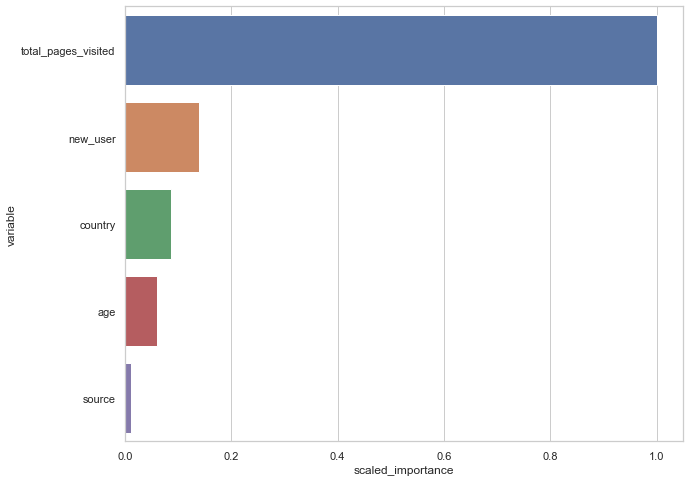

In [73]:
# Feature importance
importance = model.varimp(use_pandas=True)

fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(x='scaled_importance', y='variable', data=importance)
plt.show()

Interesting! New user is the most important one. Source doesn’t seem to matter at all.

In [74]:
# Make predictions
train_true = train.as_data_frame()['converted'].values
test_true = test.as_data_frame()['converted'].values
train_pred = model.predict(train).as_data_frame()['p1'].values
test_pred = model.predict(test).as_data_frame()['p1'].values

train_fpr, train_tpr, _ = roc_curve(train_true, train_pred)
test_fpr, test_tpr, _ = roc_curve(test_true, test_pred)
train_auc = np.round(auc(train_fpr, train_tpr), 3)
test_auc = np.round(auc(test_fpr, test_tpr), 3)

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


In [75]:
# Classification report
print(classification_report(y_true=test_true, y_pred=(test_pred > 0.5).astype(int)))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     76500
           1       0.83      0.63      0.72      2550

    accuracy                           0.98     79050
   macro avg       0.91      0.81      0.86     79050
weighted avg       0.98      0.98      0.98     79050



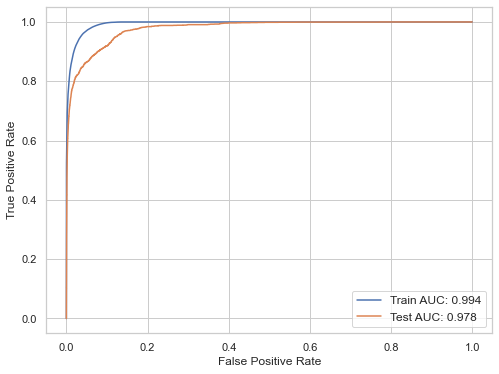

In [76]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(train_fpr, train_tpr, label='Train AUC: ' + str(train_auc))
ax.plot(test_fpr, test_tpr, label='Test AUC: ' + str(test_auc))
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.legend(fontsize=12)
plt.show()

PartialDependencePlot progress: |████████████████████████████████████████████████| (done) 100%


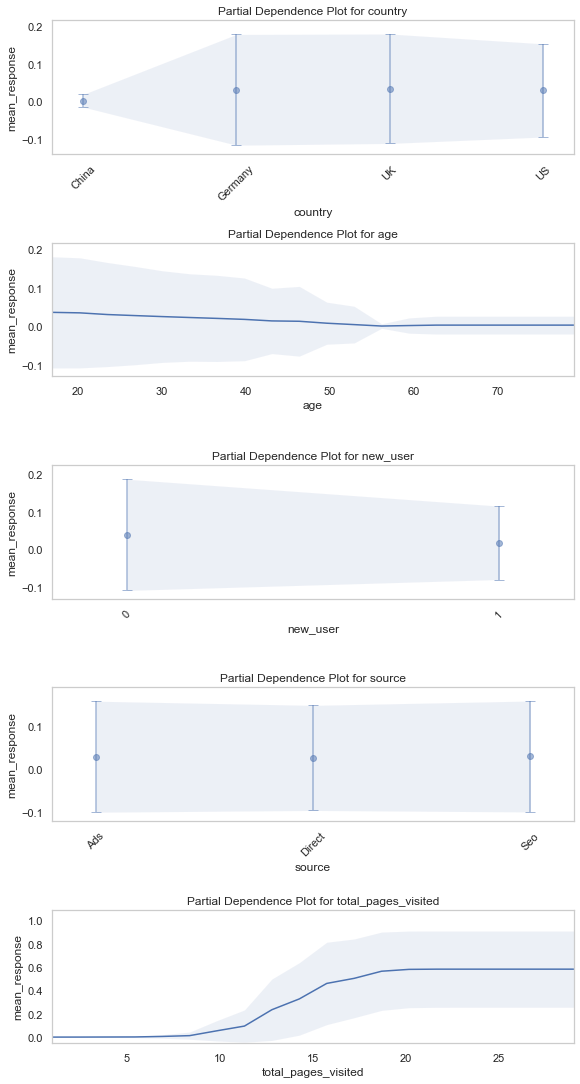

In [77]:
_ = model.partial_plot(train, cols=feature, figsize=(8, 15))

In partial dependence plots, we just care about the trend, not the actual y value. So this shows that:
- Users with an old account are much better than new users
- China is really bad, all other countries are similar with Germany being the best
- The site works very well for young people and bad for less young people (>30 yrs old)
- Source is irrelevant

In [78]:
# Shutdown h2o instance
h2o.cluster().shutdown()

H2O session _sid_86af closed.


## Decision Tree

In [80]:
# Initialize H2O cluster
h2o.init()
h2o.remove_all()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; OpenJDK 64-Bit Server VM JBR-11.0.13.7-1751.21-jcef (build 11.0.13+7-b1751.21, mixed mode)
  Starting server from C:\Users\yijia\anaconda3\envs\py3-TF2.0\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\yijia\AppData\Local\Temp\tmpw5n1wpob
  JVM stdout: C:\Users\yijia\AppData\Local\Temp\tmpw5n1wpob\h2o_yijia_started_from_python.out
  JVM stderr: C:\Users\yijia\AppData\Local\Temp\tmpw5n1wpob\h2o_yijia_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.1.3
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_yijia_66i38u
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.912 Gb
H2O_cluster_total_cores:,16
H2O_cluster_allowed_cores:,16
H2O_cluster_status:,"locked, healthy"


In [81]:
# Transform to H2O Frame, and make sure the target variable is categorical
h2o_df = H2OFrame(data)

h2o_df['new_user'] = h2o_df['new_user'].asfactor()
h2o_df['converted'] = h2o_df['converted'].asfactor()

h2o_df.summary()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


,country,age,new_user,source,total_pages_visited,converted
type,enum,int,enum,enum,int,enum
mins,,17.0,,,1.0,
mean,,30.5693110013347,,,4.872918234777034,
maxs,,79.0,,,29.0,
sigma,,8.268957596421474,,,3.3410533442156267,
zeros,,0,,,0,
missing,0,0,0,0,0,0
0,UK,25.0,1,Ads,1.0,0
1,US,23.0,1,Seo,5.0,0
2,US,28.0,1,Seo,4.0,0


In [82]:
# Split into 75% training and 25% test dataset
strat_split = h2o_df['converted'].stratified_split(test_frac=0.25, seed=42)

train = h2o_df[strat_split == 'train']
test = h2o_df[strat_split == 'test']

feature = ['country', 'age', 'new_user', 'source', 'total_pages_visited']
target = 'converted'

In [83]:
# Build random forest model
model = H2ORandomForestEstimator(balance_classes=True, ntrees=1, max_depth=20, 
                                 mtries=-1, seed=42, score_each_iteration=True)
model.train(x=feature, y=target, training_frame=train)

drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  DRF_model_python_1657570590543_1


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,1.0,1.0,34602.0,20.0,20.0,20.0,2745.0,2745.0,2745.0




ModelMetricsBinomial: drf
** Reported on train data. **

MSE: 0.09959438360216127
RMSE: 0.3155857785169688
LogLoss: 0.35835610987862493
Mean Per-Class Error: 0.043028299986090465
AUC: 0.9913916268475929
AUCPR: 0.9883853574049128
Gini: 0.9827832536951857

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.028488310061922113: 


,,0,1,Error,Rate
0,0,79921.0,4939.0,0.0582,(4939.0/84860.0)
1,1,2349.0,81981.0,0.0279,(2349.0/84330.0)
2,Total,82270.0,86920.0,0.0431,(7288.0/169190.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.028488,0.957442,361.0
1,max f2,0.009178,0.974983,387.0
2,max f0point5,0.102949,0.959770,293.0
3,max accuracy,0.035078,0.956936,355.0
4,max precision,0.842066,0.994593,20.0
5,max recall,0.001199,1.000000,398.0
6,max specificity,1.000000,0.997030,0.0
7,max absolute_mcc,0.028488,0.914284,361.0
8,max min_per_class_accuracy,0.051592,0.955350,339.0
9,max mean_per_class_accuracy,0.029212,0.956981,360.0



Gains/Lift Table: Avg response rate: 50.00 %, avg score: 13.64 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.095001,1.000000,1.988407,1.988407,0.994221,1.000000,0.994221,1.000000,0.188900,0.188900,98.840730,98.840730,0.187802
1,2,0.100421,0.942677,1.996750,1.988858,0.998392,0.948193,0.994446,0.997204,0.010823,0.199723,99.674976,98.885760,0.198607
2,3,0.150115,0.302263,1.948410,1.975468,0.974222,0.617184,0.987751,0.871402,0.096825,0.296547,94.840971,97.546772,0.292870
3,4,0.200081,0.009502,1.361651,1.822179,0.680837,0.109900,0.911105,0.681232,0.068037,0.364584,36.165056,82.217885,0.329011
4,5,1.000000,0.000000,0.794351,1.000000,0.397182,0.000072,0.500009,0.136360,0.635416,1.000000,-20.564940,0.000000,0.000000




Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
0,,2022-07-11 16:21:59,0.137 sec,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,,2022-07-11 16:22:00,1.339 sec,1.0,0.315586,0.358356,0.991392,0.988385,1.988407,0.043076



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,total_pages_visited,43164.296875,1.000000,0.624028
1,country,15004.259766,0.347608,0.216917
2,age,5493.775391,0.127276,0.079424
3,new_user,4550.484863,0.105422,0.065787
4,source,957.634216,0.022186,0.013845


In [92]:
from sklearn.tree import plot_tree # tree diagram

AttributeError: type object 'ModelBase' has no attribute 'tree_'

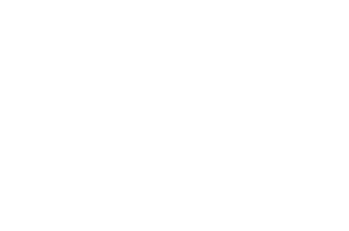

In [96]:

plot_tree(model) # model is your xgboost model, choose which tree in num_trees and layout direction default if top to bottom, LR is left to right
